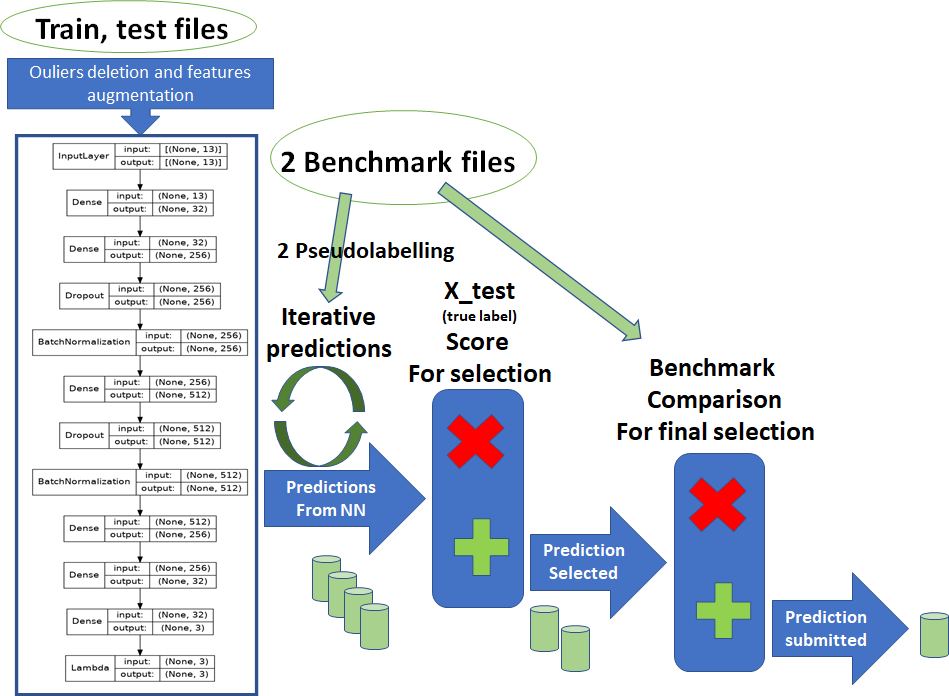

Pseudolabel inpired from TPS LightAutoML baseline (with pseudolabels) made by the famous Alexander Ryzhkov !<h3>
2 files for pseudolabelling are used. X_test has true labels.
The Neural Network prediction is compared with a benchmark file from Somayyeh Gholami & Mehran Kazeminia, smart ensembling.
The 75%, 50% and 25% percentiles are evaluated.
The best prediction of the Neural Network is recorded if above thresholds on score from the benchmark comparison and the X_test (with true label) MSLE score

Thank's to BIZEN :
https://www.kaggle.com/hiro5299834/tps-jul-2021-pycaret-with-pseudo-labels
and :
@junhyeok99 https://www.kaggle.com/junhyeok99/automl-pycaret


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

import math

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations,callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from keras.models import Model


In [ ]:
train = pd.read_csv('../input/tabular-playground-series-jul-2021/train.csv')
test = pd.read_csv("../input/tabular-playground-series-jul-2021/test.csv")
sample_submission = pd.read_csv("../input/tabular-playground-series-jul-2021/sample_submission.csv")
minmax = MinMaxScaler()
train.shape

In [ ]:
"""
from Somayyeh Gholami & Mehran Kazeminia and Alexander Ryzhkov, smart ensembling based upon :
Thanks to: @paddykb https://www.kaggle.com/paddykb/tps-07-gam-baseline
Thanks to: @junhyeok99 https://www.kaggle.com/junhyeok99/automl-pycaret
Thanks to: https://www.kaggle.com/hiro5299834/tps-jul-2021-pycaret-with-pseudo-labels 
"""
bench = pd.read_csv("../input/benchmark21/benchmark.csv")
bench1 = pd.read_csv("../input/benchmark23/submission_3.csv")
name1 = ["date_time","carbon1","benzene1","nitrogen1"]
name2 = ["date_time","carbon2","benzene2","nitrogen2"]
bench.columns = name1
bench1.columns = name2
train = pd.concat([train,train.iloc[:,-3:]],axis=1)
train.shape

In [ ]:
a=[]
a = list([x for x in train.columns])
a = a[:-6]
a.extend(name1[1:])
a.extend(name2[1:])
train.columns = a

<h2> Features augmentation

In [ ]:
train['date_time'] = train['date_time'].astype('datetime64[ns]')
train['hour'] = train['date_time'].dt.hour
train['day'] = train['date_time'].dt.day
train['weekday'] = train['date_time'].dt.dayofweek
train["working_hours"] =  train["hour"].isin(np.arange(8, 21, 1)).astype("int")
train["weekend"] = (train["date_time"].dt.dayofweek >= 5).astype("int")

In [ ]:
test['date_time'] = test['date_time'].astype('datetime64[ns]')
test['hour'] = test['date_time'].dt.hour
test['day'] = test['date_time'].dt.day
test['weekday'] = test['date_time'].dt.dayofweek
test["working_hours"] =  test["hour"].isin(np.arange(8, 21, 1)).astype("int")
test["weekend"] = (test["date_time"].dt.dayofweek >= 5).astype("int")

In [ ]:
test['date_time'] = test['date_time'].astype(np.int64)/10**18
train['date_time'] = train['date_time'].astype(np.int64)/10**18

In [ ]:
test = test[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5'
                 ]]

In [ ]:
#Double pseudolabelling :
test_labels = pd.concat([test,bench.iloc[:,1:], bench1.iloc[:,1:]],axis = 1)
test_labels

In [ ]:
train = train[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'sensor_2',
                'sensor_3',
                'sensor_4',
                'sensor_5',
                'carbon1',
                'benzene1',
                'nitrogen1',
                'carbon2',
                'benzene2',
                'nitrogen2'
                 ]]

In [ ]:
all_train = pd.concat([train,test_labels],axis = 0,ignore_index=True)
all_train.shape

In [ ]:
all_train['sensor_6'] = (all_train['sensor_2']-all_train['sensor_5']) / all_train['sensor_5']
all_train['sensor_7'] = (all_train['sensor_3']-all_train['sensor_4']) / all_train['sensor_4']

shift = all_train['sensor_1'].shift(periods=1,fill_value=0)
dif1 = all_train['sensor_1']-shift
all_train['evolution_sensor_1']= dif1

shift = all_train['sensor_2'].shift(periods=1,fill_value=0)
dif2 = all_train['sensor_2']-shift
all_train['evolution_sensor_2']= dif2

shift = all_train['sensor_3'].shift(periods=1,fill_value=0)
dif3 = all_train['sensor_3']-shift
all_train['evolution_sensor_3']= dif3

shift = all_train['sensor_4'].shift(periods=1,fill_value=0)
dif4 = all_train['sensor_4']-shift
all_train['evolution_sensor_4']= dif4

shift = all_train['sensor_5'].shift(periods=1,fill_value=0)
dif5 = all_train['sensor_5']-shift
all_train['evolution_sensor_5']= dif5


In [ ]:
all_train1 = []
all_train1 = all_train[['date_time',
                'deg_C',
                'hour',
                'day',
                'weekday',
                'weekend',
                'working_hours',
                'relative_humidity',
                'absolute_humidity',
                'sensor_1',
                'evolution_sensor_1',
                'sensor_2',
                'evolution_sensor_2',
                'sensor_3',
                'evolution_sensor_3',
                'sensor_4',
                'evolution_sensor_4',
                'sensor_5',
                'evolution_sensor_5',
                'sensor_6',
                'sensor_7',
                'carbon1',
                'benzene1',
                'nitrogen1',
                'carbon2',
                'benzene2',
                'nitrogen2'
                 ]]
all_train1.shape

<h2> Features rescaling

In [ ]:
#---- with double pseudo label ------
all_train_sc = pd.DataFrame(minmax.fit_transform(all_train1.iloc[:,:-6]))
test_sc = all_train_sc.iloc[len(train):,:]
train_sc = all_train_sc.iloc[:len(train),:]
y_sc = all_train1.iloc[:,-6:]
all_train.shape, y_sc.shape,test_sc.shape,train_sc.shape

<h2> Loss and metric functions for NN

In [ ]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()
mse = tf.keras.losses.MeanSquaredError()

es = tf.keras.callbacks.EarlyStopping(
    monitor= 'val_loss', min_delta=1e-12, patience=10, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True)

plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.7, patience=2, verbose=0,
    mode='auto')

<h2> Model definition

In [ ]:
def reg_model():

    reg_inputs = layers.Input(shape = (21))
   
    x = layers.Dense(
            units = 128, 
            activation ='relu',
            kernel_initializer ='he_uniform')(reg_inputs)
    
    x = layers.Dense(
            units = 512, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)
    
    x = layers.Dense(
            units = 2048, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)
    
    x = layers.Dense(
            units = 512, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)

    x = layers.Dense(
            units = 128, 
            activation ='relu',
            kernel_initializer ='he_uniform')(x)
        
    reg_outputs = layers.Dense(
            units = 6,
        activation = 'linear',
        kernel_initializer ='he_uniform',name = 'last')(x)

    #----------- Model instantiation  ---------------
    model = Model(reg_inputs,reg_outputs)

    return model

In [ ]:
# ---- Test definition with True label -----
ind_start = train.shape[0]-(24*7*2) #test for the 3 last weeks
ind_stop = train.shape[0]
X_train = pd.concat([all_train_sc.iloc[:ind_start,:],all_train_sc.iloc[ind_stop:,:]])
X_test = all_train_sc.iloc[ind_start:ind_stop,:] 
y_train = pd.concat([y_sc.iloc[:ind_start,:],y_sc.iloc[ind_stop:,:]])
y_test = y_sc.iloc[ind_start:ind_stop,:]
X_train.shape,X_test.shape,y_train.shape,y_test.shape

In [ ]:
y_train_log = y_train.copy()
y_test_log = y_test.copy()
y_train_log.iloc[:,0] = y_train.iloc[:,0].map(lambda x : math.log(x+1))
y_train_log.iloc[:,1] = y_train.iloc[:,1].map(lambda x : math.log(x+1))
y_train_log.iloc[:,2] = y_train.iloc[:,2].map(lambda x : math.log(x+1))
y_train_log.iloc[:,3] = y_train.iloc[:,3].map(lambda x : math.log(x+1))
y_train_log.iloc[:,4] = y_train.iloc[:,4].map(lambda x : math.log(x+1))
y_train_log.iloc[:,5] = y_train.iloc[:,5].map(lambda x : math.log(x+1))
y_test_log.iloc[:,0] = y_test.iloc[:,0].map(lambda x : math.log(x+1))
y_test_log.iloc[:,1] = y_test.iloc[:,1].map(lambda x : math.log(x+1))
y_test_log.iloc[:,2] = y_test.iloc[:,2].map(lambda x : math.log(x+1))
y_test_log.iloc[:,3] = y_test.iloc[:,3].map(lambda x : math.log(x+1))
y_test_log.iloc[:,4] = y_test.iloc[:,4].map(lambda x : math.log(x+1))
y_test_log.iloc[:,5] = y_test.iloc[:,5].map(lambda x : math.log(x+1))

<h2> Benchmark preparation before training and submission (no blending)

In [ ]:
# We will use this benchmark to evaluate the quality of the training
#bench = pd.concat([bench.iloc[:,1:],bench1.iloc[:,1:]],axis = 1)
bench_stat = bench.describe() 
bench_stat

<h2> Training and best prediction choice

In [ ]:
ROUND =400 # Several iterations because of the stochastic calculation
pred_3 = np.zeros((len(test_sc),3))
pred_final = np.zeros((len(test_sc),3))
print('======== TRAINING STARTING ============\n')
approved = 0

for i in range(ROUND):
    
    tf.keras.backend.clear_session()
    model = reg_model()
    model.compile(loss=msle,optimizer = keras.optimizers.Adam())
    model.fit(X_train,y_train_log,
              batch_size = 64, 
              epochs = 100,
              validation_data=(X_test,y_test_log),
              callbacks=[es, plateau],
              verbose =0)
    pred = model.predict(X_test)
    pred[:,0] = np.exp(pred[:,0])-1
    pred[:,1] = np.exp(pred[:,1])-1
    pred[:,2] = np.exp(pred[:,2])-1
    pred[:,3] = np.exp(pred[:,3])-1
    pred[:,4] = np.exp(pred[:,4])-1
    pred[:,5] = np.exp(pred[:,5])-1
    
    
    pred = np.where(pred>0,pred,0)
    
    score = np.round(mean_squared_log_error(y_test, pred),5)
    print(f"Score for round {i} on X_test :", score)
    
    # In case of multiple iterations, we can reject anomalous predictions :
    if (score <= 0.027
       ) == True:
        approved += 1
        print(f"round {i} approved for benchmarking analysis ")
        pred_test = model.predict(test_sc)
        pred_test[:,0] = np.exp(pred_test[:,0])-1
        pred_test[:,1] = np.exp(pred_test[:,1])-1
        pred_test[:,2] = np.exp(pred_test[:,2])-1
        pred_test[:,3] = np.exp(pred_test[:,3])-1
        pred_test[:,4] = np.exp(pred_test[:,4])-1
        pred_test[:,5] = np.exp(pred_test[:,5])-1
        pred_test = np.where(pred_test>0,pred_test,0.05)
        pred_3[:,0] = (pred_test[:,0]+pred_test[:,3])/2
        pred_3[:,1] = (pred_test[:,1]+pred_test[:,4])/2
        pred_3[:,2] = (pred_test[:,2]+pred_test[:,5])/2
        

        # Run analysis :
        df = pd.concat([pd.DataFrame(pred_test).describe(),pd.DataFrame(bench_stat)], axis = 1)
        
        carbon_75 = np.abs((df.iloc[6,0]-df.iloc[6,6])/df.iloc[6,6])
        benzene_75 = np.abs((df.iloc[6,1]-df.iloc[6,7])/df.iloc[6,7])
        nitrogen_75 = np.abs((df.iloc[6,2]-df.iloc[6,8])/df.iloc[6,8])
        
        carbon_50 = np.abs((df.iloc[5,0]-df.iloc[5,6])/df.iloc[5,6])
        benzene_50 = np.abs((df.iloc[5,1]-df.iloc[5,7])/df.iloc[5,7])
        nitrogen_50 = np.abs((df.iloc[5,2]-df.iloc[5,8])/df.iloc[5,8])
        
        carbon_25 = np.abs((df.iloc[4,0]-df.iloc[4,6])/df.iloc[4,6])
        benzene_25 = np.abs((df.iloc[4,1]-df.iloc[4,7])/df.iloc[4,7])
        nitrogen_25 = np.abs((df.iloc[4,2]-df.iloc[4,8])/df.iloc[4,8])
        
        run_75 =100 *(carbon_75 + benzene_75 + nitrogen_75)/3
        run_50 =100 *(carbon_50 + benzene_50 + nitrogen_50)/3
        run_25 =100 *(carbon_25 + benzene_25 + nitrogen_25)/3
        
        print(f'Benchmark GAP at 75% :{run_75}% at 50% :{run_50}% at 25% :{run_25}%\n')
        if ((run_75 < 1.1) & (run_50 < 1) & (run_25 < 1.1))== True :
            pred_final += pred_3
            print("PREDICTION RECORDED")
            print(f"Final GAP 75% :{run_75} GAP 50% :{run_50} GAP 25% :{run_25}")
            break
        else :
            print('PREDICTION REJECTED \n')
    else :
        print(f"round {i} rejected \n")

    
print(f"\n====== End of the training :{approved} accepted rounds for this training =====\n")

<h2> Benchmark analysis (no blending)

In [ ]:
sample_submission['target_carbon_monoxide'] = pred_final[:,-3]
sample_submission['target_benzene'] = pred_final[:,-2]
sample_submission['target_nitrogen_oxides'] = pred_final[:,-1]

In [ ]:
sample_submission.to_csv('sub_NN_double_pseudo_3.csv',index = False)